In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.color import rgb2gray
%matplotlib inline

from sklearn import metrics
import matplotlib.image as mpimg
import random
from scipy import interp
from itertools import cycle
import datetime 

import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Import/Reduce Kaggle

In [0]:
data_raw = pd.read_csv("drive/My Drive/sign_mnist_train.csv")
test_data_raw = test = pd.read_csv("drive/My Drive/sign_mnist_test.csv")

In [0]:
# Break up data and labels
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

# Normalize data
data_full = data_raw.values/255
labels_full = labels.values
test_data_full = test_data_raw.values/255 
labels_test_full = labels_test.values 

# Concatenate training and test set
X_MNIST_full = np.concatenate((data_full, test_data_full))
y_MNIST_full = np.concatenate((labels_full,labels_test_full))

# Get rid of unused letters and the letters c, g, and h
X_MNIST = []
y_MNIST = []
for i in range(len(y_MNIST_full)):
  if (y_MNIST_full[i] <= 8 and y_MNIST_full[i] != 2 and y_MNIST_full[i] != 6 and y_MNIST_full[i] != 7): #ADDED THE LAST AND STATEMENT TO GET RID OF I's
    X_MNIST.append(X_MNIST_full[i])
    y_MNIST.append(y_MNIST_full[i])
X_MNIST = np.asarray(X_MNIST)
y_MNIST = np.asarray(y_MNIST)

# Reshape data to 50x50
X_MNIST_50 = []
for i in range (len(X_MNIST)):
  img_flat_orig = X_MNIST[i];
  img_2d_orig = img_flat_orig.reshape(28, 28)
  img_2d_new = cv2.resize(img_2d_orig, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_1d_new = img_2d_new.flatten()
  X_MNIST_50.append(img_1d_new)
X_MNIST_50 = np.asarray(X_MNIST_50)

In [4]:
X_MNIST_50.shape

(8696, 2500)

In [5]:
letter_count = np.zeros(9)
for i in range(len(y_MNIST)):
  letter_count[y_MNIST[i]] += 1
print(letter_count)

[1457. 1442.    0. 1441. 1455. 1451.    0.    0. 1450.]


In [6]:
# grab all the indexes for eahc letter

idx = np.ones((9,1457))*-1 #this will hold the index values for each letter, will be -1 if rest of row is not full
for i in range(len(y_MNIST)):
  curr_let = y_MNIST[i]
  curr_row = idx[curr_let]
  unique_elements, counts_elements = np.unique(curr_row, return_counts=True)
  next_idx = len(unique_elements) - 1
  idx[curr_let][next_idx] = i
  #print(len(unique_elements))
print(idx)

[[ 9.000e+00  1.100e+01  1.200e+01 ...  8.683e+03  8.684e+03  8.686e+03]
 [ 5.000e+00  6.000e+00  1.900e+01 ... -1.000e+00 -1.000e+00 -1.000e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]
 ...
 [-1.000e+00 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]
 [ 1.000e+00  1.600e+01  3.100e+01 ... -1.000e+00 -1.000e+00 -1.000e+00]]


In [0]:
# randomly choose 700 index for each letter to reduce the Kaggle dataset size to 50%
X_MNIST_reduced = []
y_MNIST_reduced = []
for i in range(idx.shape[0]):
  if (i == 2 or i == 6 or i == 7):
    continue
  for j in range(700):
    ran_num = random.randint(0,idx.shape[1]-1)
    while (idx[i][ran_num] == -1):
      ran_num = random.randint(0,idx.shape[1]-1)
    X_MNIST_reduced.append(X_MNIST_50[idx[i][ran_num].astype(int)])
    y_MNIST_reduced.append(y_MNIST[idx[i][ran_num].astype(int)])
X_MNIST_reduced = np.asarray(X_MNIST_reduced)
y_MNIST_reduced = np.asarray(y_MNIST_reduced)

In [8]:
X_MNIST_reduced.shape, y_MNIST_reduced.shape

((4200, 2500), (4200,))

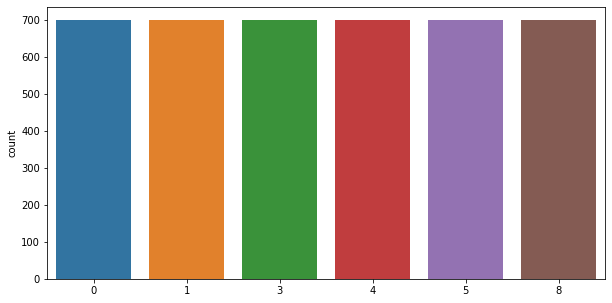

In [9]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_MNIST_reduced);

##Import/Data Augment Class Data

In [0]:
X_class_orig = np.load('drive/My Drive/train_data.npy')
y_class_orig = np.load('drive/My Drive/train_labels.npy')

In [11]:
y_class_orig.shape

(1844, 1)

In [0]:
# Change letters to numbers
letters = {'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4, 
                        'F': 5,'G': 6, 'H': 7,'I': 8}
y_class_or = []
for i in range(len(y_class_orig)):
  y_class_or.append(letters[y_class_orig[i][0]])
y_class_or = np.asarray(y_class_or)

# Normalize and format data
X_class_or = []
for i in range(X_class_orig.shape[0]):
  img = X_class_orig[i]
  img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_g = rgb2gray(img_r)
  img_1d = img_g.flatten()
  X_class_or.append(img_1d)
X_class_or = np.asarray(X_class_or)

In [14]:
X_class_or.shape, y_class_or.shape

((1844, 2500), (1844,))

In [15]:
# take some original class images for testing purposes
X_train_or, X_test_or, y_train_or, y_test_or = train_test_split(X_class_or, y_class_or,
                                                                 test_size=0.5, random_state=4)
X_train_or.shape, X_test_or.shape

((922, 2500), (922, 2500))

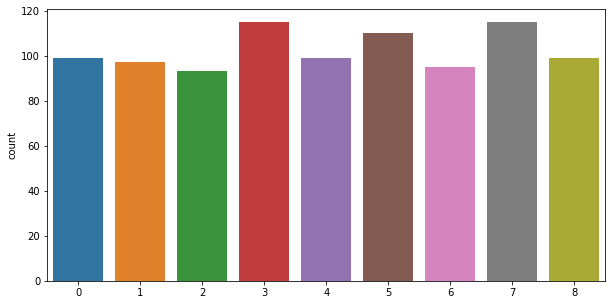

In [16]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_train_or);

In [0]:
# https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da
def anticlockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

def warp_shift(image): 
    transform = AffineTransform(translation=(0,40)) 
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [18]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise}

X_new_class = []
y_new_class = []
X_using = X_train_or
y_using = y_train_or

# Lets data augment class data by 600 each, or 600*9 = 5400

images_to_generate = 5400
i = 1
while i <= images_to_generate:
  img_idx = random.randint(0, len(X_using)-1)
  y_new_class.append(y_using[img_idx])
  original_image = X_using[img_idx].reshape(50,50)
  transformed_image=None
  n = 0  
  transformation_count = random.randint(1, len(transformations))
  while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      transformed_image = transformations[key](original_image)
      n = n + 1
  trans_img = transformed_image.flatten()
  X_new_class.append(trans_img);
  i += 1
X_new_class = np.asarray(X_new_class)
y_new_class = np.asarray(y_new_class)
X_new_class.shape, y_new_class.shape

((5400, 2500), (5400,))

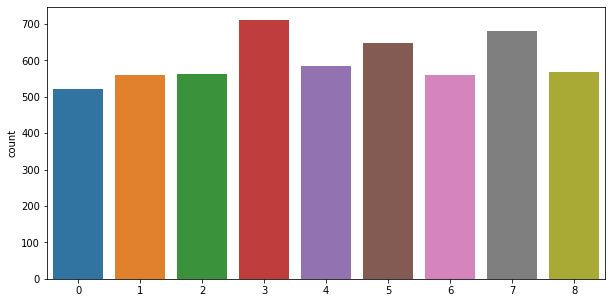

In [19]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_new_class);

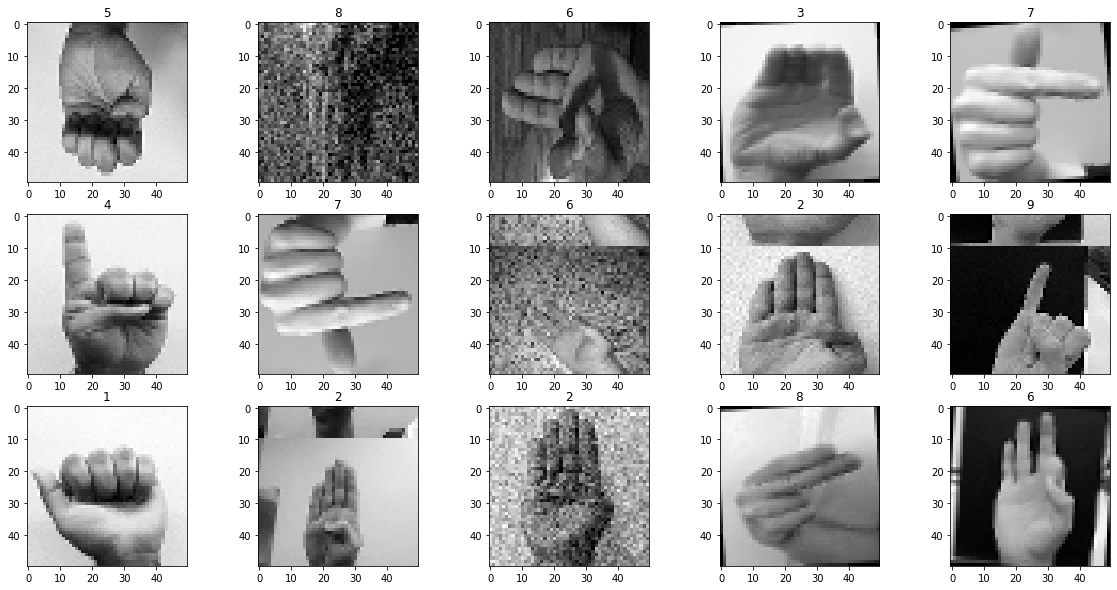

In [20]:
plt.figure(figsize=(20,10))
for i in range(1,16):
    idx = random.randint(0, len(X_new_class))
    img = X_new_class[idx]
    plt.subplot(3,5,i)
    plt.title(y_new_class[idx]+1)
    plt.imshow(img.reshape(50,50), cmap='gray');

In [0]:
#X_train_class, X_test_orig_class, y_train_class, y_test_orig_class = train_test_split(
 #   X_class_otest, y_class_otest, test_size=0.6, random_state=4)
#X_test_orig_class.shape, y_test_orig_class.shape

###Add C Data

In [0]:
C_data = np.load('drive/My Drive/C/data.npy')
C_labels = np.load('drive/My Drive/C/labels.npy')

In [0]:
C_labels.resize(709,1)

In [0]:
#X_class_raw_C = np.concatenate((X_class_orig, C_data))
#y_class_raw_C = np.concatenate((y_class_orig, C_labels))

In [0]:
# Change letters to numbers
letters = {'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4, 
                        'F': 5,'G': 6, 'H': 7,'I': 8}
y_C = []
for i in range(len(C_labels)):
  y_C.append(letters[C_labels[i][0]])
y_C = np.asarray(y_C)

# Normalize and format data
X_C = []
for i in range(C_data.shape[0]):
  img = C_data[i]
  img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_g = rgb2gray(img_r)
  img_1d = img_g.flatten()
  X_C.append(img_1d)
X_C = np.asarray(X_C)

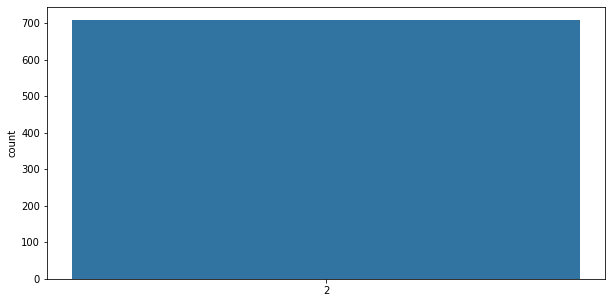

In [54]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_C);

##Combine Kaggle and Class

###Without Extra C Data

In [45]:
X_train_comb_noC = np.concatenate((X_MNIST_reduced, X_new_class))
y_train_comb_noC = np.concatenate((y_MNIST_reduced, y_new_class))
X_train_comb_noC.shape, y_train_comb_noC.shape

((9600, 2500), (9600,))

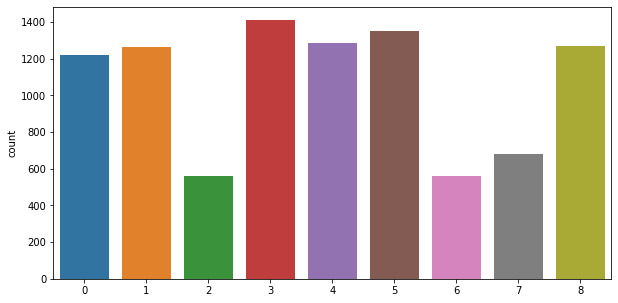

In [46]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_train_comb_noC);

###With Extra C Data

In [55]:
X_train_comb_C = np.concatenate((X_MNIST_reduced, X_new_class, X_C))
y_train_comb_C = np.concatenate((y_MNIST_reduced, y_new_class, y_C))
X_train_comb_C.shape, y_train_comb_C.shape

((10309, 2500), (10309,))

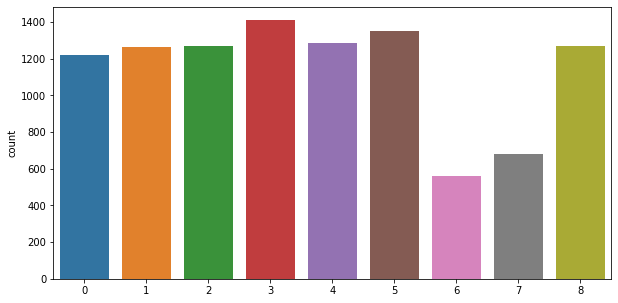

In [56]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_train_comb_C);

##Train Model

In [0]:
# https://www.kaggle.com/justuser/sign-language-classifier-convnet-with-pytorch
 class Network(nn.Module):   
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30*9*9, 270) 
        self.fc4 = nn.Linear(270, 9) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 9 * 9) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

Epoch: 1 - Loss: 2.141183
Epoch: 2 - Loss: 1.983350
Epoch: 3 - Loss: 1.481651
Epoch: 4 - Loss: 1.171285
Epoch: 5 - Loss: 0.805523
Epoch: 6 - Loss: 0.629854
Epoch: 7 - Loss: 0.888754
Epoch: 8 - Loss: 0.513857
Epoch: 9 - Loss: 0.455059
Epoch: 10 - Loss: 0.423714
Epoch: 11 - Loss: 0.485047
Epoch: 12 - Loss: 0.342952
Epoch: 13 - Loss: 0.250401
Epoch: 14 - Loss: 0.354874
Epoch: 15 - Loss: 0.350205
Epoch: 16 - Loss: 0.216521
Epoch: 17 - Loss: 0.296534
Epoch: 18 - Loss: 0.307419
Epoch: 19 - Loss: 0.303643
Epoch: 20 - Loss: 0.198550
Epoch: 21 - Loss: 0.206213
Epoch: 22 - Loss: 0.217820
Epoch: 23 - Loss: 0.171107
Epoch: 24 - Loss: 0.270363
Epoch: 25 - Loss: 0.160415
Epoch: 26 - Loss: 0.123907
Epoch: 27 - Loss: 0.134229
Epoch: 28 - Loss: 0.073010
Epoch: 29 - Loss: 0.108881
Epoch: 30 - Loss: 0.154684
Epoch: 31 - Loss: 0.258635
Epoch: 32 - Loss: 0.077082
Epoch: 33 - Loss: 0.213816
Epoch: 34 - Loss: 0.107316
Epoch: 35 - Loss: 0.113780
Epoch: 36 - Loss: 0.048028
Epoch: 37 - Loss: 0.061510
Epoch: 38 

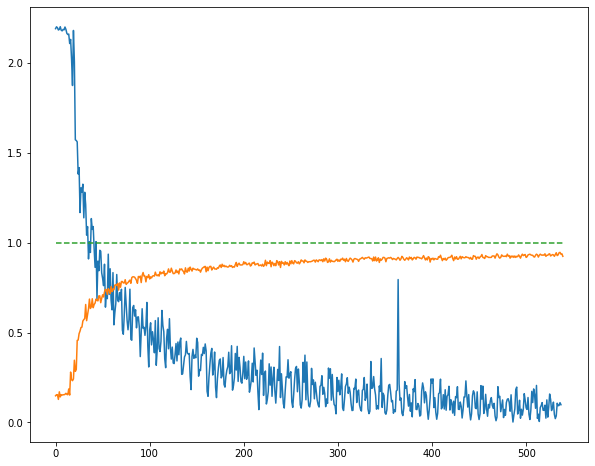

In [57]:
# function takes in incorrect format of training data, NEED TO FIX
#def train(X_train, Y_train):
  X_train = X_train_comb_C
  Y_train = y_train_comb_C
  X_2d = []
  for i in X_train:
        X_2d.append(i.reshape(1, 50, 50))
  X_2d = np.array(X_2d)

  X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(
      X_2d, Y_train, test_size=0.2, random_state=4)

  X = torch.FloatTensor(X_train_set)
  y = torch.LongTensor(y_train_set.tolist())

  X_test = torch.FloatTensor(X_val_set)
  y_test = torch.LongTensor(y_val_set.tolist())

  epochs = 60
  batch_size = 100
  learning_rate = 0.08

  net = Network()
  optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
  loss_func = nn.CrossEntropyLoss()

  net.train()
  loss_log = []
  acc_log = []
  for e in range(epochs):
      for i in range(0, X.shape[0], batch_size):
          X_batch = X[i:i + batch_size] 
          y_batch = y[i:i + batch_size] 
          
          optimizer.zero_grad()
          net_out = net(Variable(X_batch))
          
          loss = loss_func(net_out, Variable(y_batch))
          loss.backward()
          optimizer.step()
          
          if i % 1000 == 0:
              #pred = net(Variable(test_data_formated))
              loss_log.append(loss.item())
              acc_log.append(net.evaluate(torch.max(net(Variable(X_test[:500])).data, 1)[1], 
                                          y_test[:500]))
          
      print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

  plt.figure(figsize=(10,8))
  plt.plot(loss_log[2:])
  plt.plot(acc_log)
  plt.plot(np.ones(len(acc_log)), linestyle='dashed')

  #return net

##Testing Model

In [0]:
def convert_2d(data, dim):
    data_new = []
    for i in data:
        data_new.append(i.reshape(1, dim, dim))
    return np.array(data_new)

Correct predictions:   742 /   922 (0.804772)
CNN for Class test set  Overall average:  0.8004338394793926
CNN for Class test set   A  accuracy:  0.8617021276595744
CNN for Class test set   B  accuracy:  0.8350515463917526
CNN for Class test set   C  accuracy:  0.7924528301886793
CNN for Class test set   D  accuracy:  0.8295454545454546
CNN for Class test set   E  accuracy:  0.7327586206896551
CNN for Class test set   F  accuracy:  0.891566265060241
CNN for Class test set   G  accuracy:  0.9021739130434783
CNN for Class test set   H  accuracy:  0.7669902912621359
CNN for Class test set   I  accuracy:  0.6853146853146853
[[81  1  3  3  0  2  1  1  2]
 [ 0 81  4  3  3  6  0  0  0]
 [ 2  8 84  0  6  4  1  1  0]
 [ 3  2  2 73  2  1  1  2  2]
 [ 4  5 13  1 85  0  4  2  2]
 [ 1  3  1  1  1 74  1  0  1]
 [ 1  0  1  3  0  0 83  4  0]
 [ 2  0  3  2  1  3 12 79  1]
 [11  8  1  4  8  5  7  1 98]]


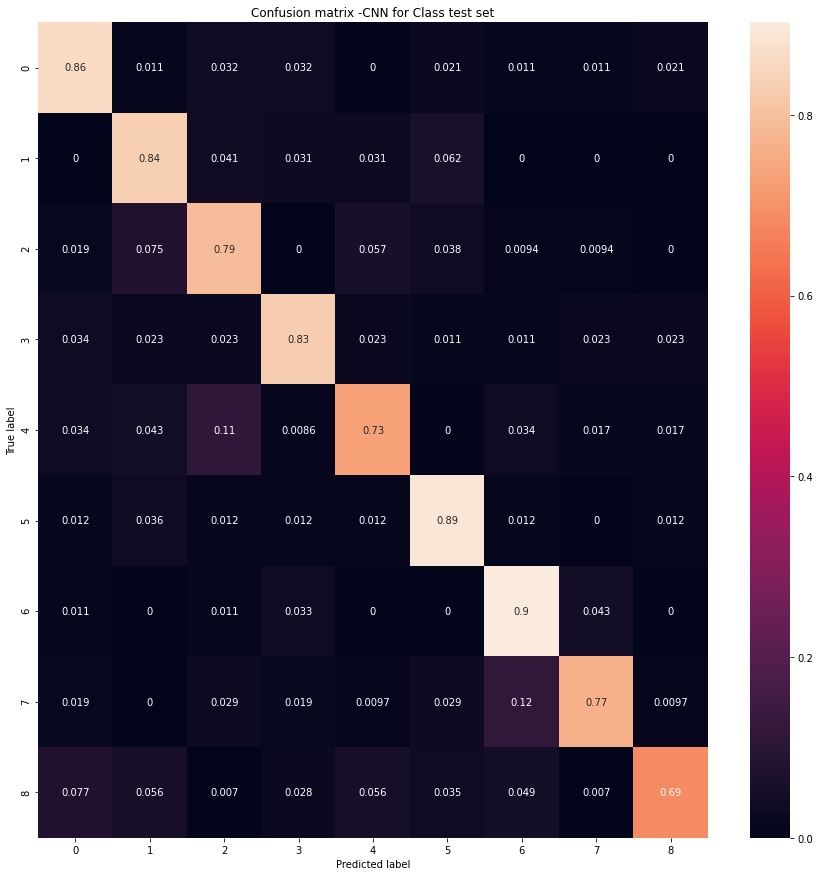

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


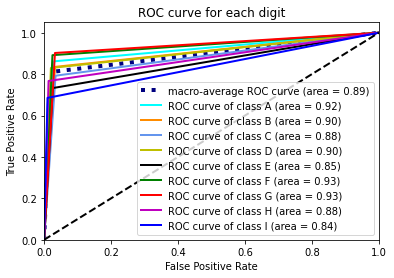

In [58]:
# Testing against class dataset
possibleLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

net.eval()
X_test_2d = convert_2d(X_test_or, 50)
X_class_test = torch.FloatTensor(X_test_2d)
y_class_test = torch.LongTensor(y_test_or.tolist())

predictions = net(Variable(X_class_test))
net.test(torch.max(predictions.data, 1)[1], y_class_test)
performMetrics(predictions.data, y_class_test, possibleLabels, "CNN for Class test set")

In [0]:
def convert2DTo1D(arr):
    if (len(arr) == 0):
        return;
    temp = np.array(arr[0]);
    for i in range(1,len(arr)):
        temp = np.append(temp, arr[i]);
    return temp

#Convert all the photos into 1D arrays
def convertAllPhotosTo1DArrays(threeDArr):
    if (len(threeDArr.shape) < 2):
        print("Array size is not 3D")
        return threeDArr;
    twoDArr = np.zeros(shape=(len(threeDArr),10000))
    for i in range(len(threeDArr)):
        twoDArr[i] = convert2DTo1D(threeDArr[i])
    return twoDArr

#Calculates the accuracy for each class
def createAccuracyPerClassArray(y_actual, y_predict, labels):
    correct = [0] * len(labels)
    total = [0] * len(labels)
    for i in range(len(y_actual)):
        if y_actual[i] == y_predict[i]:
            correct[labels.index(y_actual[i])] += 1
        total[labels.index(y_actual[i])] += 1
    accuracy = [0] * len(labels)
    for i in range(len(correct)):
        if (total[i] == 0):
          accuracy[i] = 0
        else:
          accuracy[i] = correct[i] / total[i]
    return accuracy

def makeAccuracyGraph(arr, training, startingNum=0, title=""):
    plt.figure(figsize=(10,6))
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='blue', linestyle='dashed', marker="o",
            markerfacecolor='red', markersize=10, label="Test")
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='green', linestyle='-.', marker="o",
            markerfacecolor='purple', markersize=10, label="Training")
    plt.title("Accuracy vs" + title)
    plt.xlabel(title)
    plt.ylabel("Accuracy")

#Prints the perclass accuracy
def printPerClassAccuracies(accuracy, labels, title=""):
      for i in range(len(accuracy)):
        print(title, " ", labels[i], " accuracy: ", accuracy[i])
    
#Prints the overall accuracy and the per class accuracy for each N 
#(for example, if I were testing K different neighbors for KNN, the arr would be len(K), the perClass would be a 2D array with [K, len(labels)])
def printAccuracies(arr, training, perClass, labels, startingNum = 0, title=""):
    for i in range(len(arr)):
        print(title, " - ", startingNum+i, " overall accuracy: ", arr[i])
        print("Per class accuracies for ", title, startingNum+i)
        printPerClassAccuracies(perClass[i],labels)

    makeAccuracyGraph(arr, training, startingNum, title)

#Metrics function
def performMetrics(y_te, y_pre, labels, name=""):
    y_test = [-1] * y_te.shape[0] #Create a N sized array, where N is the size of the training set
    i_max = -1000
    for i in range(len(y_te)):
      i_max = -1
      for j in range(len(y_te[i])): 
        if y_te[i][j] > i_max:
          i_max = y_te[i][j]
          y_test[i] = j
      #JD6 We could easily just test here that if it is less than a threshold leave it at -1
      #y_test[i] = j #if i_max < threshold

    y_predict = y_pre.tolist()

    #Converting them to be the letters
    for i in range(len(y_predict)):
      y_test[i] = labels[y_test[i]]
      y_predict[i] = labels[y_predict[i]]

    count = 0
    for i in range(len(y_test)):
        count += 1 if (y_test[i] == y_predict[i]) else 0
    print(name, " Overall average: ", (count/len(y_test)))

    perClass = createAccuracyPerClassArray(y_test,y_predict,labels)
    printPerClassAccuracies(perClass, labels, name)

    #Confusion Maxtrix - Lecture 10
    C = metrics.confusion_matrix(y_test,y_predict,labels=labels)
    print(C)
    C_scaled = list()
    #Scaling each value
    #JD6, may have to put an array of possible labels here?
    for row in range(0,len(C)):
        total = 0
        C_scaled.append(list())
        for col in range(0,len(C[row])):
            total += C[row][col] 
        for col in range(0,len(C[row])):
            C_scaled [row].append(C[row][col] / total) 
            #Divide each one to get the %

    plt.figure(figsize = (15,15))
    ax = plt.axes()
    sns.heatmap(C_scaled, annot=True)

    ax.set_title("Confusion matrix -" + name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()

    #Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Compute ROC curve and ROC area for each class
    lw = 2
    n_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        #From Dr. Silvia's OH
        y_t = [True] * len(y_test)
        y_p = [True] * len(y_test)
        for j in range(len(y_test)):
          y_t[j] = 1 if (y_test[j] == labels[i]) else 0
          y_p[j] = 1 if (y_predict[j] == labels[i]) else 0
        fpr[labels[i]], tpr[labels[i]], _ = metrics.roc_curve(y_t, y_p)
        roc_auc[labels[i]] = metrics.auc(fpr[labels[i]], tpr[labels[i]])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[labels[i]] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[labels[i]], tpr[labels[i]])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "y", "k", "g", "r", "m", "b", "c"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[labels[i]], tpr[labels[i]], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[labels[i]]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each digit')
    plt.legend(loc="lower right")
    plt.show()